<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/portfolio_optimization_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part of this code is taken from the tutorial by Chi-Chun Chen: https://eric08000800.medium.com/portfolio-optimization-with-variational-quantum-eigensolver-vqe-2-477a0ee4e988

In [1]:
#%matplotlib inline
#!pip install pennylane
#!pip install qulacs pennylane-qulacs
#!pip install seaborn
#!pip install lightning
#!pip install ipynbname
#!pip install pandas
#!pip install yfinance==0.2.50

In [2]:
import pandas as pd
import yfinance as yf

assets = "AAPL MSFT AMZN TSLA GOOG BRK-B IBM BAC BB CTLT SONY F" # KO LYG" # MCD NOK"
StockStartDate = '2024-01-01'
StockEndDate = '2024-12-31'
interval = '1d'

df = yf.download(assets, start=StockStartDate,\
                 end=StockEndDate, interval=interval)['Adj Close']

# daily return distribution
ret = df.pct_change().dropna()

# mean return vector & covariance matrix (annualized)
R = ret.mean()*252
Sigma = ret.cov()*252

[*********************100%***********************]  12 of 12 completed
C:\Users\mbrat\AppData\Local\Temp\ipykernel_78356\2788360031.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = df.pct_change().dropna()


In [3]:
import pennylane as qml
from pennylane import numpy as np

# define parameters in H
N = 12      # number of total assets
gamma = 1  # risk aversion coefficient
B = 3      # budget ?increase this?
P = 1.0    # penalty

ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j] + P) for i in range(N) for j in range(i+1,N)]
Z = [qml.PauliZ(i) for i in range(N)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]
C = 0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma))- 0.5*sum(R) + 0.25*P*(N + (N-2*B)**2)

# Construct the problem Hamiltonian
obs = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

C:\Users\mbrat\AppData\Local\Temp\ipykernel_78356\1151362757.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]


In [4]:
# Compute the exact ground state energy
ground_energy = H.eigendecomposition['eigval'][0]

In [5]:
ground_energy

-12.447380744683148

In [6]:
# Design the ansatz
p = 2     # circuit repetitions
def ansatz(params, qubits, depth=p):
    for q in range(qubits):
            qml.RY(params[q], wires=q)
    for d in range(1,depth+1):
        for q in range(qubits-1):
            qml.CNOT(wires=[q,q+1])
        for q in range(qubits):
            qml.RY(params[d*qubits+q], wires=q)

In [7]:
dev = qml.device("lightning.qubit", wires=N)

# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=N)
    return qml.probs(wires=range(N))

In [8]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm
import pennylane as qml
#from pennylane.utils import _flatten, unflatten
from pennylane import GradientDescentOptimizer
import copy
#from MomentumQNGOptimizer import MomentumQNGOptimizer

In [9]:
def plot_opt_data(opt_delta_energy,opt_steps,opt_title,opt_color):
    fig = plt.figure(figsize=(12, 3), layout="compressed")
    axs = fig.subplots(1, 2, sharey=False)
    #fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=False)

    # We can set the number of bins with the *bins* keyword argument.
    ave_delta_energy = 0
    for i in range(len(opt_delta_energy)):
        ave_delta_energy += opt_delta_energy[i]
    ave_delta_energy /= len(opt_delta_energy)
    delta_bins = [i*0.04 for i in range(51)]
    steps_bins = [i for i in range(steps+1)]
    axs[0].hist(opt_delta_energy, bins=delta_bins,color=opt_color,label="mean(dE)=" + str(np.round(ave_delta_energy,3)))
    axs[1].hist(opt_steps, bins=steps_bins,color=opt_color)
    axs[0].set_xlabel("delta energy")
    axs[0].set_ylabel("count")
    axs[0].legend()
    axs[1].set_xlabel("steps")
    axs[1].set_ylabel("count")
    plt.suptitle(opt_title)
    plt.show()

In [10]:
def run_session(optimizer,optimizer_params,init_params_array,steps):
    opt_params = []
    opt_steps = []
    opt_delta_energy = []

    for init_params in tqdm(init_params_array):
        opt = copy.deepcopy(optimizer)
        for id in optimizer_params:
            setattr(opt, id, optimizer_params[id])
        params = init_params
        prev_cost = 9999.999999
        try:
            for i in range(steps):
                params = opt.step(cost, params)
                cur_cost = cost(params)
                if (i + 1) % 3 == 0:
                    if np.round(prev_cost, 3) == np.round(cur_cost, 3):
                        break
                    else:
                        prev_cost = cur_cost
            opt_params.append(params)
            opt_steps.append(i)
            opt_delta_energy.append(cur_cost - ground_energy)
        except:
            print(init_params)

    return (opt_params,opt_steps,opt_delta_energy)

In [11]:
sessions = [
    {"optimizer" :  qml.AdamOptimizer(),
     "params" : {"beta1" : 0.9, "beta2" : 0.99, "epsilon" : 1.0e-8},
     "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
     "stepsizes" : [0.15,0.175,0.2,0.225,0.25]}
]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mbrat\AppData\Local\Temp\ipykernel_78356\544295256.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
C:\Users\mbrat\AppData\Local\Temp\ipykernel_78356\544295256.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^{-8}$",
C:\Users\mbrat\AppData\Local\Temp\ipykernel_78356\544295256.py:4: SyntaxWarning: invalid escape sequence '\m'
  "params_name" : "$\mathit{"+ chr(946) + "}_1$=0.9, $\mathit{"+ chr(946) + "}_2$=0.99, $\mathit{"+ chr(949) +"}$=$10^

In [12]:
init_count = 200
steps = 200

seed_value = 736520

init_params_array = []
np.random.seed(seed_value)
for i in range(init_count):
    init_params_array.append(np.random.rand((p+1)*N))

100%|██████████| 200/200 [1:17:56<00:00, 23.38s/it]


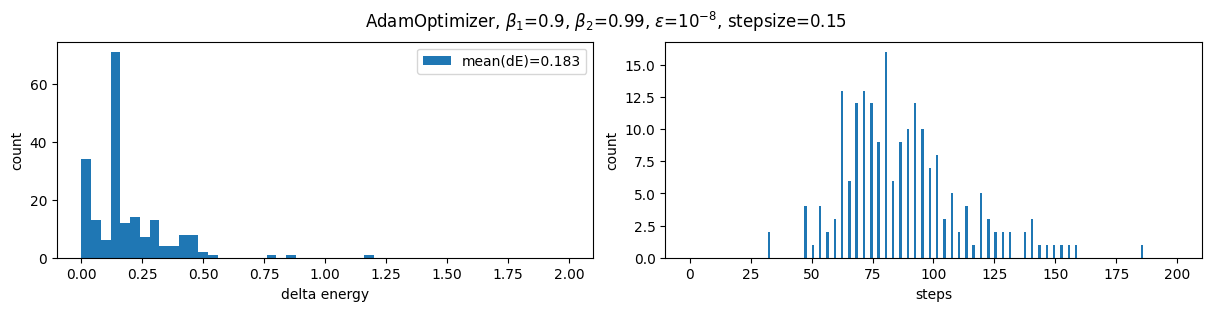

100%|██████████| 200/200 [1:23:02<00:00, 24.91s/it]


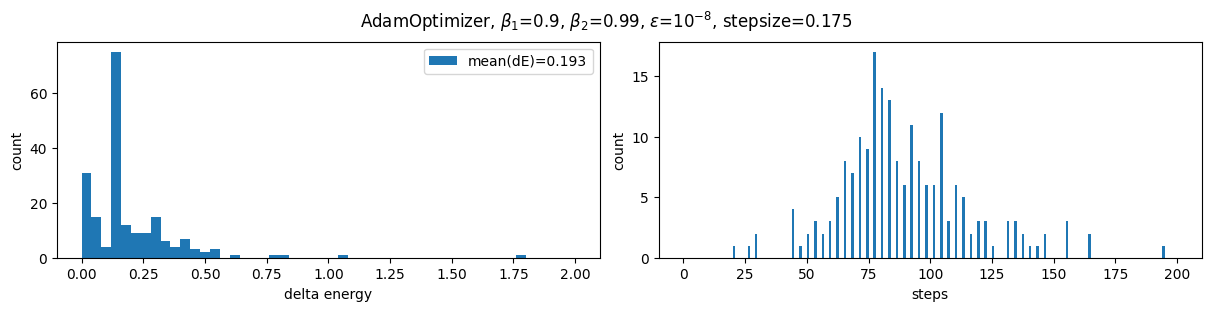

100%|██████████| 200/200 [1:18:23<00:00, 23.52s/it]


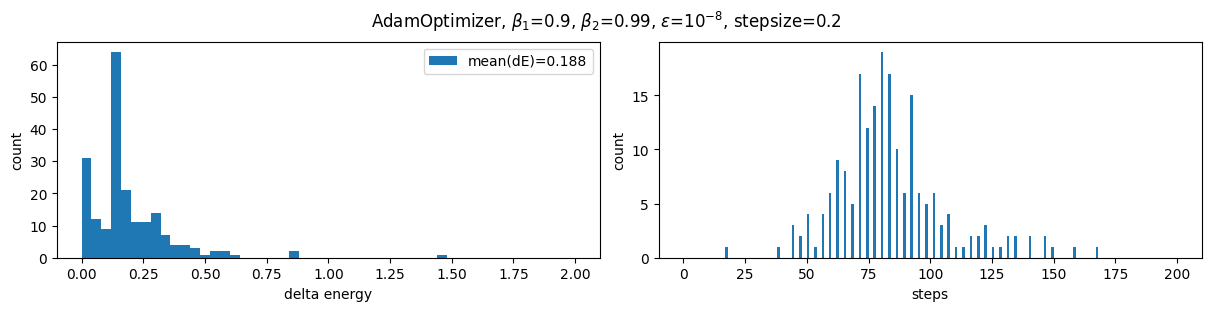

100%|██████████| 200/200 [1:16:36<00:00, 22.98s/it]


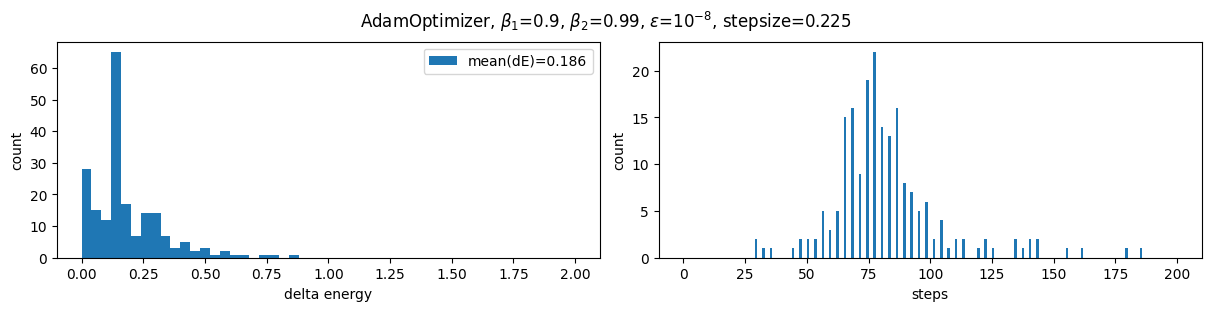

100%|██████████| 200/200 [5:37:11<00:00, 101.16s/it]    


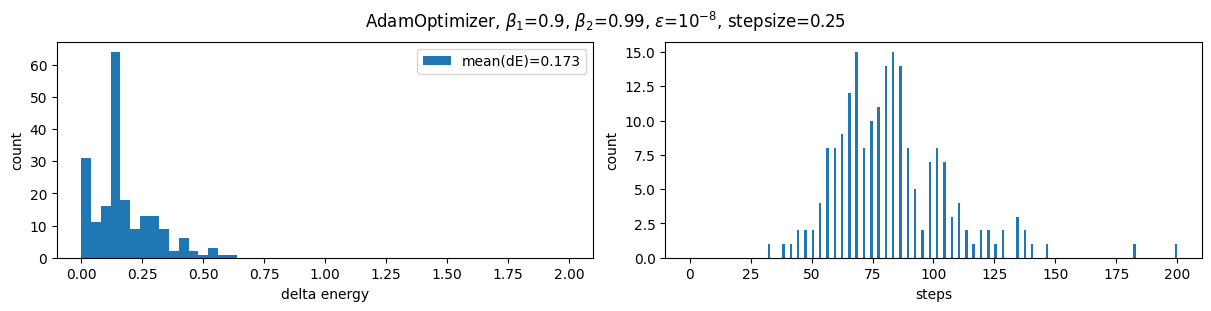

In [13]:
sessions_params = []
sessions_steps = []
sessions_delta_energy = []

for i,session in enumerate(sessions):
    cur_params = []
    cur_steps = []
    cur_delta_energy = []
    for stepsize in session["stepsizes"]:
        session_params = copy.deepcopy(session["params"])
        session_params["stepsize"] = stepsize
        (opt_params,opt_steps,opt_delta_energy) = run_session(session["optimizer"],session_params,init_params_array,steps)
        title = session["optimizer"].__class__.__name__
        if(len(session["params_name"]) > 0):
            title += ", "+ session["params_name"]
        title += ", stepsize=" + str(stepsize)
        plot_opt_data(opt_delta_energy,opt_steps,title,'C'+str(i))
        cur_params.append(opt_params)
        cur_steps.append(opt_steps)
        cur_delta_energy.append(opt_delta_energy)

    sessions_params.append(cur_params)
    sessions_steps.append(cur_steps)
    sessions_delta_energy.append(cur_delta_energy)


In [14]:
from datetime import date
import ipynbname


start_name = ipynbname.name() + "_"
tail_name = "_" + str(date.today()) + ".dat"

first_line = "initNo "
for i in range(len(sessions)):
    for k in range(len(sessions[i]["stepsizes"])):
        try:
            first_line += str(sessions[i]["stepsizes"][k]) + " "
        except:
            print("")

with open(start_name + "delta_energy" + tail_name, "w") as file:
    print(first_line,file=file)
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_delta_energy[i][k][j]) + " "
                except:
                    print(j)
        print(j,line,file=file)

with open(start_name + "steps" + tail_name, "w") as file:
    print(first_line,file=file)
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_steps[i][k][j]) + " "
                except:
                    print(j)
        print(j,line,file=file)

with open(start_name + "params" + tail_name, "w") as file:
    print(first_line,file=file)
    for j in range(len(init_params_array)):
        line = ""
        for i in range(len(sessions)):
            for k in range(len(sessions[i]["stepsizes"])):
                try:
                    line += str(sessions_params[i][k][j][0]) + " " + str(sessions_params[i][k][j][1]) + " "
                except:
                    print(j)
        print(j,line,file=file)
